#  Homework 5 - Berkeley STAT 157

**Your name: Zhiming, SID 3034485754** (Please add your name, and SID to ease Ryan and Rachel to grade.)

**Please submit your homework through [gradescope](http://gradescope.com/) instead of Github, so you will get the score distribution for each question. Please enroll in the [class](https://www.gradescope.com/courses/42432) by the Entry code: MXG5G5** 

Handout 2/19/2019, due 2/26/2019 by 4pm in Git by committing to your repository.

In this homework, we will model covariate shift and attempt to fix it using logistic regression. This is a fairly realistic scenario for data scientists. To keep things well under control and understandable we will use [Fashion-MNIST](http://d2l.ai/chapter_linear-networks/fashion-mnist.html) as the data to experiment on. 

Follow the instructions from the Fashion MNIST notebook to get the data.

In [1]:
%matplotlib inline
from mxnet import autograd, gluon, init, nd
from mxnet.gluon import data as gdata, loss as gloss, nn, utils
import d2l
import numpy as np
import matplotlib.pyplot as plt
import mxnet as mx
import time

## 1. Logistic Regression

1. Implement the logistic loss function $l(y,f) = -\log(1 + \exp(-y f))$ in Gluon.
2. Plot its values and its derivative for $y = 1$ and $f \in [-5, 5]$, using automatic differentiation in Gluon.
3. Generate training and test datasets for a binary classification problem using Fashion-MNIST with class $1$ being a combination of `shirt` and `sweater` and class $-1$ being the combination of `sandal` and `sneaker` categories. 
4. Train a binary classifier of your choice (it can be linear or a simple MLP such as from a previous lecture) using half the data (i.e. $12,000$ observations mixed as abvove) and one using the full dataset (i.e. $24,000$ observations as arising from the 4 categories) and report its accuracy. 

Hint - you should encapsulate the training and reporting code in a callable function since you'll need it quite a bit in the following. 

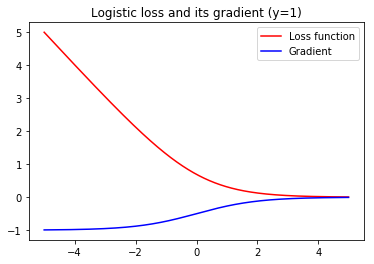

In [4]:
# for question 1 & 2
def logistic_loss(f, y):
    l = nd.log(1.0+nd.exp(-f*y))
    return l
f = nd.arange(-5, 5, 0.01)
f.attach_grad()
# for y = 1
y = nd.ones(shape = f.shape)
with autograd.record():
    l = logistic_loss(f, y)
l.backward()
# for loss function
plt.figure()
plt.title('Logistic loss and its gradient (y=1)')
plt.plot(f.asnumpy(), l.asnumpy(), color = 'r',\
         label = 'Loss function')
# for grad
plt.plot(f.asnumpy(), f.grad.asnumpy(), color = 'b',\
        label = 'Gradient')
plt.legend(loc = 'upper right')
plt.show()

In [2]:
mnist_train = gdata.vision.FashionMNIST(train=True, transform = lambda data, label:\
                                        (data.astype(np.float32), label))
mnist_test = gdata.vision.FashionMNIST(train=False, transform = lambda data, label:\
                                        (data.astype(np.float32), label))

In [3]:
# for question 3
#X, y = train[0:9]
# pick out pullover/shirt, and sneaker/scandal
# a new preprocess function, can produce biased dataset
def preprocess(mnist_train, mnist_test, total_per_label, ratio): # ratio is the lambda above
    X, y = mnist_train[:]
    # pick up the indices
    index_sweater = np.where(y==3)[0]
    index_shirt = np.where(y==6)[0]
    index_scandal = np.where(y==5)[0]
    index_sneaker = np.where(y==7)[0]
    # create the class for training, biased
    class_sweater = X[index_sweater[0:round(total_per_label*ratio)]]
    class_shirt = X[index_shirt[0:round(total_per_label*ratio)]]
    class_scandal = X[index_scandal[0:round(total_per_label*(1-ratio))]]
    class_sneaker = X[index_sneaker[0:round(total_per_label*(1-ratio))]]
    # print(class_sweater.shape, class_shirt.shape, class_scandal.shape, class_sneaker.shape)
    train_feature = nd.concat(class_sweater, class_shirt, class_scandal, class_sneaker, dim=0)
    label1 = nd.ones((1, total_per_label)).astype(np.float32)
    label2 = nd.zeros((1, total_per_label)).astype(np.float32)
    train_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    train_data = gdata.dataset.ArrayDataset(train_feature, train_labels)
    # create the class for testing, unbiased
    X, y = mnist_test[:]
    index1 = np.where(np.logical_or(y==3, y==6))[0]
    index2 = np.where(np.logical_or(y==5, y==7))[0]
    class1 = X[index1]
    class2 = X[index2]
    test_feature = nd.concat(class1, class2, dim=0)
    
    label1 = nd.ones((1, 2000)).astype(np.float32)
    label2 = nd.zeros((1, 2000)).astype(np.float32)
    test_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    test_data = gdata.dataset.ArrayDataset(test_feature, test_labels)
    
    return train_data, test_data

In [4]:
def train_and_test_mnist(train_data, test_data, batch_size, lr, num_epochs):
    net = nn.Sequential()
    net.add(nn.Dense(2))
    net.initialize(init.Normal(sigma=0.01))
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    #loss = logistic_loss
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': lr})
    d2l.train_ch3(net, train_data, test_data, loss, num_epochs, batch_size, None, None, trainer)

In [18]:
# half the dataset 
# note: use half the dataset, test acc is almost the same as using the full dataset
# so I used just 50 per label for train (total 100 for training), which leads to
# observable difference in test acc (~.975 v.s. ~.999)
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=50, ratio=0.5) # ratio=.5 for equally division
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.1, num_epochs=5)
# full dataset
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=12000, ratio=0.5) # ration=.5 for equally division
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.1, num_epochs=5)

epoch 1, loss 0.5813, train acc 0.710, test acc 0.971
epoch 2, loss 0.1732, train acc 0.990, test acc 0.978
epoch 3, loss 0.1293, train acc 1.000, test acc 0.979
epoch 4, loss 0.1063, train acc 1.000, test acc 0.981
epoch 5, loss 0.0910, train acc 1.000, test acc 0.982
epoch 1, loss 0.0279, train acc 0.995, test acc 0.997
epoch 2, loss 0.0104, train acc 0.998, test acc 0.998
epoch 3, loss 0.0080, train acc 0.998, test acc 0.998
epoch 4, loss 0.0068, train acc 0.999, test acc 0.998
epoch 5, loss 0.0061, train acc 0.999, test acc 0.999


## 2. Covariate Shift

Your goal is to introduce covariate shit in the data and observe the accuracy. For this, compose a dataset of $12,000$ observations, given by a mixture of `shirt` and `sweater` and of `sandal` and `sneaker` respectively, where you use a fraction $\lambda \in \{0.05, 0.1, 0.2, \ldots 0.8, 0.9, 0.95\}$ of one and a fraction of $1-\lambda$ of  the other datasets respectively. For instance, you might pick for $\lambda = 0.1$ a total of $600$ `shirt` and $600$ `sweater` images and likewise $5,400$ `sandal` and $5,400$ `sneaker` photos, yielding a total of $12,000$ images for training. Note that the test set remains unbiased, composed of $2,000$ photos for the `shirt` + `sweater` category and of the `sandal` + `sneaker` category each.

1. Generate training sets that are appropriately biased. You should have 11 datasets.
2. Train a binary classifier using this and report the test set accuracy on the unbiased test set. 

In [5]:
total_per_label = 6000
num_epochs = 8
print("Bias ratio now is:", .05)
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=total_per_label, ratio=0.05)
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.01, num_epochs=num_epochs)
for r in range(1, 9, 1):
    ratio = r / 10.0
    print("Bias ratio now is:", ratio, "(unbiased)" if ratio==.5 else "")
    train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=total_per_label, ratio=ratio)
    batch_size = 64
    train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.01, num_epochs=num_epochs)
print("Bias ratio now is:", .95)
train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label=total_per_label, ratio=0.95)
batch_size = 64
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_and_test_mnist(train_data, test_data, batch_size=batch_size, lr=0.01, num_epochs=num_epochs)

Bias ratio now is: 0.05
epoch 1, loss 1030.9001, train acc 0.825, test acc 0.786
epoch 2, loss 533.5384, train acc 0.878, test acc 0.782
epoch 3, loss 461.3527, train acc 0.882, test acc 0.798
epoch 4, loss 517.8337, train acc 0.881, test acc 0.757
epoch 5, loss 416.5679, train acc 0.889, test acc 0.792
epoch 6, loss 387.4597, train acc 0.891, test acc 0.802
epoch 7, loss 463.1350, train acc 0.882, test acc 0.805
epoch 8, loss 435.3261, train acc 0.887, test acc 0.785
Bias ratio now is: 0.1 
epoch 1, loss 962.3865, train acc 0.802, test acc 0.789
epoch 2, loss 725.9215, train acc 0.839, test acc 0.771
epoch 3, loss 675.1344, train acc 0.845, test acc 0.782
epoch 4, loss 664.9490, train acc 0.845, test acc 0.776
epoch 5, loss 583.3890, train acc 0.851, test acc 0.803
epoch 6, loss 633.9865, train acc 0.852, test acc 0.788
epoch 7, loss 592.8555, train acc 0.854, test acc 0.848
epoch 8, loss 595.3522, train acc 0.849, test acc 0.763
Bias ratio now is: 0.2 
epoch 1, loss 1064.6700, train 

## 3. Covariate Shift Correction

Having observed that covariate shift can be harmful, let's try fixing it. For this we first need to compute the appropriate propensity scores $\frac{dp(x)}{dq(x)}$. For this purpose pick a biased dataset, let's say with $\lambda = 0.1$ and try to fix the covariate shift.

1. When training a logistic regression binary classifier to fix covariate shift, we assumed so far that both sets are of equal size. Show that re-weighting data in training and test set appropriately can help address the issue when both datasets have different size. What is the weighting?
    - We can set the weights as $.5/\lambda$ for the class with fraction $\lambda$, and $.5/(1-\lambda)$ for the class with fraction $1-\lambda$.
2. Train a binary classifier (using logistic regression) distinguishing between the biased training set and the unbiased test set. Note - you need to weigh the data. 
3. Use the scores to compute weights on the training set. Do they match the weight arising from the biasing distribution $\lambda$? 
4. Train a binary classifier of the covariate shifted problem using the weights obtained previously and report the accuracy. Note - you will need to modify the training loop slightly such that you can compute the gradient of a weighted sum of losses. 


### For question 1, weighted loss for training

In [6]:
# a new preprocess procedure, 0/1 for two labels
def preprocess(mnist_train, mnist_test, total_per_label, ratio): # ration is the lambda above
    X, y = mnist_train[:]
    # pick up the indices
    index_sweater = np.where(y==3)[0]
    index_shirt = np.where(y==6)[0]
    index_scandal = np.where(y==5)[0]
    index_sneaker = np.where(y==7)[0]
    # create the class for training, biased
    class_sweater = X[index_sweater[0:round(total_per_label*ratio)]]
    class_shirt = X[index_shirt[0:round(total_per_label*ratio)]]
    class_scandal = X[index_scandal[0:round(total_per_label*(1-ratio))]]
    class_sneaker = X[index_sneaker[0:round(total_per_label*(1-ratio))]]
    # print(class_sweater.shape, class_shirt.shape, class_scandal.shape, class_sneaker.shape)
    train_feature = nd.concat(class_sweater, class_shirt, class_scandal, class_sneaker, dim=0)
    train_feature = nd.flatten(train_feature)
    label1 = nd.ones((1, total_per_label)).astype(np.float32)
    label2 = nd.zeros((1, total_per_label)).astype(np.float32)
    train_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    train_data = gdata.dataset.ArrayDataset(train_feature, train_labels)
    # create the class for testing, unbiased
    X, y = mnist_test[:]
    index1 = np.where(np.logical_or(y==3, y==6))[0]
    index2 = np.where(np.logical_or(y==5, y==7))[0]
    class1 = X[index1]
    class2 = X[index2]
    test_feature = nd.concat(class1, class2, dim=0)
    test_feature = nd.flatten(test_feature)
    label1 = nd.ones((1, 2000)).astype(np.float32)
    label2 = nd.zeros((1, 2000)).astype(np.float32)
    test_labels = nd.concat(label1, label2, dim=1).reshape(shape=(-1,))
    test_data = gdata.dataset.ArrayDataset(test_feature, test_labels)
    return train_data, test_data

In [26]:
# preperations
def logistic(z):
    return 1. / (1. + nd.exp(-z))
# loss function, with weight
def log_loss(output, y, ratio):
    yhat = logistic(output)
    yhat = yhat.reshape(shape=y.shape)
    # biased loss
    return  - nd.nansum(ratio/(.5+ratio) * y * nd.log(yhat) + (1-ratio)/(.5+ratio) * (1-y) * nd.log(1-yhat))
    # original loss
    # return  - nd.nansum(y * nd.log(yhat) + (1-y) * nd.log(1-yhat))
# train_model
def train_model(epochs, train_data, net, trainer, batch_size, ratio, f=None):
    for e in range(epochs):
        cumulative_loss = 0
        for i, (data, label) in enumerate(train_data):
            with autograd.record():
                if f is not None:
                    ratio = f(data)
                output = net(data)
                # print('weigth of net:', net.bias.data(), net.weight.data())
                # print('output of net:', output)
                loss = log_loss(output, label, ratio)
            loss.backward()
            trainer.step(batch_size)
            cumulative_loss += nd.sum(loss).asscalar()
        print("Epoch %s, loss: %s" % (e + 1, cumulative_loss ))
# test_model
def test_model(test_data):
    num_correct = 0.0
    num_total = 0
    for i, (data, label) in enumerate(test_data):
        num_total += len(label)
        output = net(data)
        prediction = ((nd.sign(output).reshape(shape=label.shape) + 1) / 2)
        num_correct += nd.sum(prediction == label)
    print("Accuracy: %0.3f (%s/%s)" % (num_correct.asscalar()/num_total, num_correct.asscalar(), num_total))

In [27]:
# combine train and test
def train_and_test_mnist_ratio(train_data, test_data, net, trainer, num_epochs, batch_size, ratio):
    train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label, ratio)
    train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    train_model(num_epochs, train_data, net, trainer, batch_size, ratio)
    test_model(test_data)

In [17]:
mnist_train = gdata.vision.FashionMNIST(train=True, transform = lambda data, label:\
                                        (data.astype(np.float32)/255.0, label))
mnist_test = gdata.vision.FashionMNIST(train=False, transform = lambda data, label:\
                                        (data.astype(np.float32)/255.0, label))
for i in range(1, 10, 1):
    net = nn.Dense(1)
    net.collect_params().initialize(mx.init.Normal(sigma=.1))
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.01})
    batch_size = 64
    total_per_label = 6000
    ratio = i / 10
    num_epochs = 8
    print('Bias ratio now', ratio, '(unbiased)' if i==5 else '')
    train_data, test_data = preprocess(mnist_train, mnist_test, total_per_label, ratio)
    train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
    train_and_test_mnist_ratio(train_data, test_data, net, trainer, num_epochs, batch_size, ratio)

Bias ratio now 0.1 
Epoch 1, loss: 2773.925651073456
Epoch 2, loss: 2141.0366463661194
Epoch 3, loss: 2049.3841454982758
Epoch 4, loss: 1998.9729175567627
Epoch 5, loss: 1963.376693725586
Epoch 6, loss: 1934.7372932434082
Epoch 7, loss: 1910.0781559944153
Epoch 8, loss: 1889.5444040298462
Accuracy: 0.961 (3842.0/4000)
Bias ratio now 0.2 
Epoch 1, loss: 3444.0298867225647
Epoch 2, loss: 2650.3152141571045
Epoch 3, loss: 2530.2830958366394
Epoch 4, loss: 2461.7838973999023
Epoch 5, loss: 2411.633710861206
Epoch 6, loss: 2374.1443095207214
Epoch 7, loss: 2343.180994749069
Epoch 8, loss: 2318.272636413574
Accuracy: 0.964 (3854.0/4000)
Bias ratio now 0.3 
Epoch 1, loss: 3323.6737656593323
Epoch 2, loss: 2417.885615348816
Epoch 3, loss: 2316.258683204651
Epoch 4, loss: 2264.4261116981506
Epoch 5, loss: 2228.820221424103
Epoch 6, loss: 2201.626485824585
Epoch 7, loss: 2180.4724292755127
Epoch 8, loss: 2162.8506731987
Accuracy: 0.976 (3902.0/4000)
Bias ratio now 0.4 
Epoch 1, loss: 2600.686656

### For question 3.2

In [28]:
def preprocess(mnist_train, mnist_test, total_per_label, ratio): # ration is the lambda above
    X, y = mnist_train[:]
    # pick up the indices
    index_sweater = np.where(y==3)[0]
    index_shirt = np.where(y==6)[0]
    index_scandal = np.where(y==5)[0]
    index_sneaker = np.where(y==7)[0]
    # create the class for training, biased
    class_sweater = X[index_sweater[0:round(total_per_label*ratio)]]
    class_shirt = X[index_shirt[0:round(total_per_label*ratio)]]
    class_scandal = X[index_scandal[0:round(total_per_label*(1-ratio))]]
    class_sneaker = X[index_sneaker[0:round(total_per_label*(1-ratio))]]
    # print(class_sweater.shape, class_shirt.shape, class_scandal.shape, class_sneaker.shape)
    train_feature = nd.concat(class_sweater, class_shirt, class_scandal, class_sneaker, dim=0)
    train_feature = nd.flatten(train_feature)
    label = nd.ones((1, total_per_label*2)).astype(np.float32)
    train_labels = label.reshape(shape=(-1,))
    train_data = gdata.dataset.ArrayDataset(train_feature, train_labels)
    # create the class for testing, unbiased
    X, y = mnist_test[:]
    index1 = np.where(np.logical_or(y==3, y==6))[0]
    index2 = np.where(np.logical_or(y==5, y==7))[0]
    class1 = X[index1]
    class2 = X[index2]
    test_feature = nd.concat(class1, class2, dim=0)
    test_feature = nd.flatten(test_feature)
    label = nd.zeros((1, 4000)).astype(np.float32)
    test_labels = label.reshape(shape=(-1,))
    test_data = gdata.dataset.ArrayDataset(test_feature, test_labels)
    return train_data, test_data

def generator(ratio, batch_size):
    mnist_train = gdata.vision.FashionMNIST(train=True,transform=lambda data, label: (data.astype(np.float32)/255.0, label))
    mnist_test = gdata.vision.FashionMNIST(train=False,transform=lambda data, label: (data.astype(np.float32)/255.0, label))
    bias_train, bias_test = preprocess(mnist_train, mnist_test, 6000, ratio)
    #train's label should be 1 and test's label should be 0
    f_train, l_train = bias_train[:]
    f_test, l_test = bias_test[:]
    
    l_train = nd.ones((1, 12000)).astype(np.float32)
    l_test = nd.zeros((1,4000)).astype(np.float32)
    
    trainLabel = nd.concat(l_train[:,:9000],l_test[:,:3000],dim = 1).reshape(shape=(-1,))
    testLabel = nd.concat(l_train[:,9000:],l_test[:,3000:],dim = 1).reshape(shape=(-1,))
    trainFeature = nd.concat(f_train[:9000], f_test[:3000], dim = 0)
    testFeature = nd.concat(f_train[9000:], f_test[3000:], dim = 0)

    train_data = gdata.dataset.ArrayDataset(trainFeature, trainLabel) 
    test_data = gdata.dataset.ArrayDataset(testFeature, testLabel) 
    return train_data, test_data

In [29]:
net = nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=.1))
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})
batch_size = 64
num_epochs = 10
ratio = 0.1
train_data, test_data = generator(ratio, batch_size)
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_model(num_epochs, train_data, net, trainer, batch_size, .75)
test_model(test_data)
# this is the weight function we want, save to use later
f_func = net

Epoch 1, loss: 1873.4682326316833
Epoch 2, loss: 1761.8355813026428
Epoch 3, loss: 1715.9093351364136
Epoch 4, loss: 1687.763379573822
Epoch 5, loss: 1669.9405512809753
Epoch 6, loss: 1654.2870440483093
Epoch 7, loss: 1640.740392446518
Epoch 8, loss: 1630.6720304489136
Epoch 9, loss: 1622.9325590133667
Epoch 10, loss: 1617.9165441989899
Accuracy: 0.750 (3000.0/4000)


In [11]:
def train_model(epochs, train_data, net, trainer, batch_size, ratio, f):
    for e in range(epochs):
        cumulative_loss = 0
        for i, (data, label) in enumerate(train_data):
            with autograd.record():
                output = net(data)
                # print('weigth of net:', net.bias.data(), net.weight.data())
                # print('output of net:', output)
                loss = log_loss(output, label, f(data))
            loss.backward()
            trainer.step(batch_size)
            cumulative_loss += nd.sum(loss).asscalar()
        print("Epoch %s, loss: %s" % (e + 1, cumulative_loss ))
# test_model
def test_model(test_data):
    num_correct = 0.0
    num_total = 0
    for i, (data, label) in enumerate(test_data):
        num_total += len(label)
        output = net(data)
        prediction = ((nd.sign(output).reshape(shape=label.shape) + 1) / 2)
        num_correct += nd.sum(prediction == label)
    print("Accuracy: %0.3f (%s/%s)" % (num_correct.asscalar()/num_total, num_correct.asscalar(), num_total))
net = nn.Dense(1)
net.collect_params().initialize(mx.init.Normal(sigma=.1))
trainer = gluon.Trainer(net.collect_params(), 'sgd', {'learning_rate': 0.1})
batch_size = 64
num_epochs = 10
ratio = 0.2
train_data, test_data = generator(ratio, batch_size)
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_model(num_epochs, train_data, net, trainer, batch_size, .75)
test_model(test_data)
# this is the weight function we want, save to use later
f_func = net
mnist_train = gdata.vision.FashionMNIST(train=True, transform = lambda data, label:\
                                        (data.astype(np.float32)/255.0, label))
mnist_test = gdata.vision.FashionMNIST(train=False, transform = lambda data, label:\
                                        (data.astype(np.float32)/255.0, label))
train_data, test_data = preprocess(mnist_train, mnist_test, 6000, ratio)
train_data = gluon.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_data = gluon.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)
train_model(num_epochs, train_data, net, trainer, batch_size, ratio, f=f_func)
test_model(test_data)

TypeError: train_model() missing 1 required positional argument: 'f'